In [1]:
matplotlib notebook

<IPython.core.display.Javascript object>


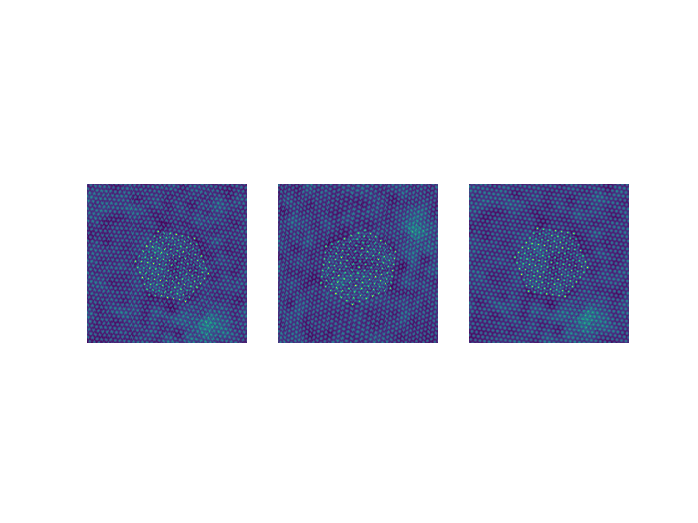

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter

file = "../data_examples/nonlinear_drift_correction_synthetic_dataset_for_testing.mat"
f = h5py.File(file, mode='r')
img1 = f['image00deg'][:]
img2 = f['image90deg'][:]
img3 = f['imageIdeal'][:]
imgs = [img1, img2, img3]

fig, AX = plt.subplots(ncols=3)
#fig.canvas.layout.width = '500px'
#fig.canvas.layout.height = '300px'


for ax, img, in zip(AX.flatten(), imgs):
    ax.imshow(img)
    ax.axis('off')
#import hyperspy.api as hs
#from scipy.io import loadmat

pi = np.pi

def sind(deg):
    return np.sin(np.deg2rad(deg))
def cosd(deg):
    return np.cos(np.deg2rad(deg))

def hanningLocal(N):
    N = N
    Dim1Window = np.sin(pi*np.arange(1,N+1)/(N+1))**2
    Dim2Window = Dim1Window[:, None]
    return Dim2Window

In [6]:
from IPython.core.debugger import set_trace


In [3]:
data = np.array([img1, img2, img1])
scanAngles = [0, 90, 0]

In [11]:
def SPmerge01(data, scanAngles):
    paddingScale = (1+1/4);#1.5;    # - padding amount for scaling of the output.
    KDEsigma = 1/2; # - Smoothing between pixels for KDE.
    edgeWidth = 1/128; # - size of edge blending relative to input images.
    linearSearch = np.linspace(-0.02,0.02,1+2*2);  # Initial linear search vector, relative to image size.

    # I have changed the convention here so that the number of images is the first axis, not the last
    # I am only supporting the case where the image input is a list / array of images 

    shape = np.array(data.shape)
    imageSize = np.round(shape[1:]*paddingScale/4).astype(int)*4;
    numImages = len(scanAngles)

    scanLines = np.zeros(shape)
    scanOr = np.zeros([numImages, 2, shape[1]])

    scanDir = np.zeros([numImages, 2])

    imageTransform = scanLines.copy()
    imageDensity = scanLines.copy()

    for a0 in range(numImages):
        xy = np.column_stack([np.arange(1,shape[1]+1), np.ones(shape[1])])
        xy[:,0] -= shape[1]/2
        xy[:,1] -= shape[2]/2
        
        xy = np.array([
            xy[:,0]*cosd(scanAngles[a0]) 
            - xy[:,1]*sind(scanAngles[a0]),
            xy[:,1]*cosd(scanAngles[a0]) 
            - xy[:,0]*sind(scanAngles[a0]),               
        ])

        xy[:,0] += imageSize[0]/2
        xy[:,1] += imageSize[1]/2
        
        xy[:,0] -= xy[0,0]%1
        xy[:,1] -= xy[1,0]%1
        scanOr[a0] = xy

        scanDir[a0] = [cosd(scanAngles[a0] + 90), sind(scanAngles[a0] + 90)];
    
    linearSearch = linearSearch * scanLines.shape[1]
    yDrift,xDrift = np.meshgrid(linearSearch, linearSearch)
    linearSearchScore1 = np.zeros(len(linearSearch))
    inds = np.linspace(-0.5,0.5,scanLines.shape[1]).T

    N = scanLines.shape

    TwoDHanningWindow = hanningLocal(N[1])*hanningLocal(N[2]).T
    padamount = imageSize - N[1:]
    pada, padb = padamount
    paddedarray = np.pad(TwoDHanningWindow, ((0, pada), (0, padb)), mode='constant', constant_values=0)

    w2 = np.roll(paddedarray, np.round(padamount/2).astype(int))

    for a0 in range(len(linearSearch)):
        for a1 in range(len(linearSearch)):
            xyShift = [inds*xDrift[a0, a1], inds*yDrift[a0, a1]]

            scanOr[:2] = np.tile(xyShift, [2,1,1])
            SPmakeImage(scanLines, imageSize, KDEsigma, scanOr, scanDir, 0)
            break
        break

In [12]:
def SPmakeImage(scanLines, imageSize, KDEsigma, scanOr, scanDir, indImage=0):
        # SPmakeImage

    indLines = np.ones(scanLines.shape[2], dtype=int)
    
    t = np.tile(np.arange(1, scanLines.shape[2]+1), [indLines.sum(dtype=int), 1])
    x0 = np.tile(scanOr[indImage, 0, indLines], [1, scanLines.shape[2]])
    y0 = np.tile(scanOr[indImage, 1, indLines], [1, scanLines.shape[2]])
    
    #set_trace()
    #print(scanDir.shape)
    xInd = x0.flatten() + t.flatten()*scanDir[indImage,0];
    yInd = y0.flatten() + t.flatten()*scanDir[indImage,1];
    
    xInd = np.maximum(np.minimum(xInd,imageSize[0]-1),1);
    yInd = np.maximum(np.minimum(yInd,imageSize[1]-1),1);
    
    
    xIndF = np.floor(xInd).astype(int)
    yIndF = np.floor(yInd).astype(int)
    xAll = np.array([xIndF, xIndF+1, xIndF, xIndF+1])
    yAll = np.array([yIndF, yIndF, yIndF+1, yIndF+1]);
    dx = xInd-xIndF
    dy = yInd-yIndF
    w = np.array([(1-dx)*(1-dy), dx*(1-dy), (1-dx)*dy, dx*dy])
    
    #print(xAll.dtype)
    #print(imageSize.dtype)
    
    indAll = np.ravel_multi_index((xAll, yAll), imageSize)
    sL = scanLines[indImage, :, indLines];

    #indAll = sub2ind(sMerge.imageSize,xAll,yAll);
    
    weights = np.array([w[0]*sL.flatten(), w[1]*sL.flatten(), w[2]*sL.flatten(), w[3]*sL.flatten()])
    accumarray = np.bincount(indAll.flatten(), weights=weights.flatten(), minlength=np.prod(imageSize))
    sig = np.reshape(accumarray, imageSize)
    
    weights2 = np.array([w[0], w[1], w[2], w[3]])
    accumarray2 = np.bincount(indAll.flatten(), weights=weights2.flatten(), minlength=np.prod(imageSize))
    
    count = np.reshape(accumarray2, imageSize);
    
    r = np.maximum(np.ceil(KDEsigma*3),5.0);
    plt.figure()
    plt.imshow(sig)
    
    #gaussian_filter()
    
    
#     % Apply KDE
#     r = max(ceil(sMerge.KDEsigma*3),5);
#     sm = fspecial('gaussian',2*r+1,sMerge.KDEsigma);
#     sm = sm / sum(sm(:));
#     sig = conv2(sig,sm,'same');
#     count = conv2(count,sm,'same');
#     sub = count > 0;
#     sig(sub) = sig(sub) ./ count(sub);
#     sMerge.imageTransform(:,:,indImage) = sig;

<IPython.core.display.Javascript object>


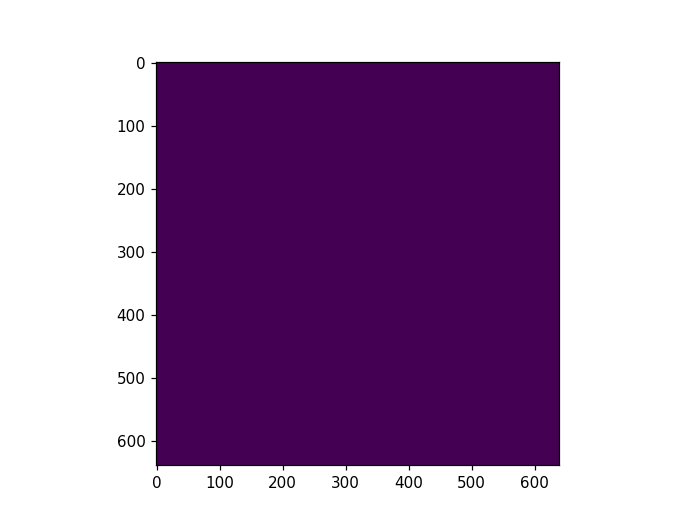

In [13]:
#%debug
SPmerge01(data, scanAngles)

In [151]:
indImage

0

In [149]:
x0.shape

(1, 262144)

In [148]:
scanDir.shape

(3, 2)

In [139]:
[1, scanLines.shape[2]]

[1, 512]

In [128]:
t = repmat(1:size(sMerge.scanLines,2),[sum(indLines) 1]);
x0 = repmat(sMerge.scanOr(indLines,1,indImage),[1 size(sMerge.scanLines,2)]);
y0 = repmat(sMerge.scanOr(indLines,2,indImage),[1 size(sMerge.scanLines,2)]);
xInd = x0(:) + t(:)*sMerge.scanDir(indImage,1);
yInd = y0(:) + t(:)*sMerge.scanDir(indImage,2);


In [121]:
scanLines[2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [118]:
scanLines.shape

(3, 512, 512)

In [112]:
%%timeit
np.tile(xyShift, [2,1,1])

7.17 µs ± 60.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [111]:
np.shape(xyShift)

(2, 512)

In [102]:
a0 = a1 = 0
xyShift = [inds*xDrift[a0, a1], inds*yDrift[a0, a1]]

array([[[ 2621.44      ,  2611.17996086,  2600.91992172, ...,
         -2600.91992172, -2611.17996086, -2621.44      ],
        [ 2621.44      ,  2611.17996086,  2600.91992172, ...,
         -2600.91992172, -2611.17996086, -2621.44      ]]])

In [ ]:
round((sMerge.imageSize-N(1:2))/2)

In [91]:
pada

128

In [87]:
imageSize - N[1:]

array([128, 128])

In [86]:
np.pad(np.ones((2,2)), ((0,2),(0,2)), 'constant')

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [79]:
imageSize - N[1:]

array([128, 128])

In [ ]:
imageSize-N(1:2)#,0,'post'

In [74]:
np.shape()

(512, 512)

In [ ]:
w2 = circshift(padarray(hanningLocal(N(1))*hanningLocal(N(2))',...
    sMerge.imageSize-N(1:2),0,'post'),round((sMerge.imageSize-N(1:2))/2));

In [ ]:
function [w] = hanningLocal(N)
% Replacement for simplest 1D hanning function to remove dependency.
w = sin(pi*((1:N)/(N+1))).^2;
end

In [58]:
hanningLocal(5)

array([0.25, 0.75, 1.  , 0.75, 0.25])

In [59]:
np.hanning(5)

array([0. , 0.5, 1. , 0.5, 0. ])

In [60]:
np.hamming(5)

array([0.08, 0.54, 1.  , 0.54, 0.08])

In [22]:
    sMerge.scanDir(a0,:) = [cos(scanAngles(a0)*pi/180 + pi/2) ...
        sin(scanAngles(a0)*pi/180 + pi/2)];

array([[  64.,   65., -254., ...,  253.,  254.,  255.],
       [  65.,   65., -255., ..., -255., -255., -255.]])

In [23]:
scanOr[1]

array([[  64.,   65., -254., ...,  253.,  254.,  255.],
       [  65.,   65., -255., ..., -255., -255., -255.]])

In [80]:
xy[0,0]%1

0.0

In [81]:
xy[0,0]

-256.0

In [43]:
scanAngles

[0, 90]

In [36]:
scanLines[:] = data

xy = [np.arange(shape[1]), np.ones(shape[1])]



In [ ]:
for a0 in len(numImages):
    scanLines[:,:,a0] = data[]